### Optimal control of phenomenological models
This notebook shows how to compute the optimal control (OC) signal for phenomenological models (FHN, Hopf) for a simple example task.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os

if os.getcwd().split(os.sep)[-1] == "examples":
    os.chdir('..')
    os.chdir('..')
    os.chdir('..')

# We import the model, stimuli, and the optimal control package
from neurolib.models.wc import WCModel
from neurolib.utils.stimulus import ZeroInput
from neurolib.optimal_control import oc_wc
from neurolib.optimal_control.oc_utils.plot_oc import plot_oc_singlenode, plot_oc_network

# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2

We stimulate the system with a known control signal, define the resulting activity as target, and compute the optimal control for this target. We define weights such that precision is penalized only (w_p=1, w_2=0). Hence, the optimal control signal should converge to the input signal.

In [8]:
# We import the model
model = WCModel()

# Some parameters to define stimulation signals
dt = model.params["dt"]
duration = 40.
amplitude = 1.
period = duration / 4.

# We define a "zero-input", and a sine-input
zero_input = ZeroInput().generate_input(duration=duration+dt, dt=dt)
input = np.copy(zero_input)
input[0,1:-1] = amplitude * np.sin(2.*np.pi*np.arange(0,duration-0.1, dt)/period) # other functions or random values can be used as well

# We set the duration of the simulation and the initial values
model.params["duration"] = duration
x_init = 0.011225367461896877
y_init = 0.013126741089502588
model.params["exc_init"] = np.array([[x_init]])
model.params["inh_init"] = np.array([[y_init]])

0.011225367461896877
0.013126741089502588


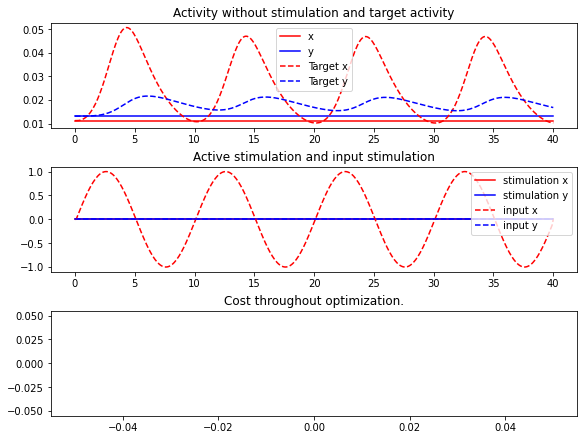

In [9]:
# We set the stimulus in x and y variables, and run the simulation
model.params["exc_ext"] = input
model.params["inh_ext"] = zero_input
model.run()

# Define the result of the stimulation as target
target = np.concatenate((np.concatenate( (model.params["exc_init"], model.params["inh_init"]), axis=1)[:,:, np.newaxis],
    np.stack( (model.exc, model.inh), axis=1)), axis=2)
target_input = np.concatenate( (input,zero_input), axis=0)[np.newaxis,:,:]

# Remove stimuli and re-run the simulation
model.params["exc_ext"] = zero_input
model.params["inh_ext"] = zero_input
control = np.concatenate( (zero_input,zero_input), axis=0)[np.newaxis,:,:]
model.run()

# combine initial value and simulation result to one array
state = np.concatenate((np.concatenate( (model.params["exc_init"], model.params["inh_init"]), axis=1)[:,:, np.newaxis],
    np.stack( (model.exc, model.inh), axis=1)), axis=2)

print(state[0,0,-1])
print(state[0,1,-1])

plot_oc_singlenode(duration, dt, state, target, control, target_input)

Compute control for a deterministic system
Cost in iteration 0: 0.08277382554315704
Cost in iteration 25: 0.0013550597034481938
Cost in iteration 50: 0.0006140959151488523
Cost in iteration 75: 0.00033632716498746
Cost in iteration 100: 0.00022305623391657346
Final cost : 0.00022305623391657346


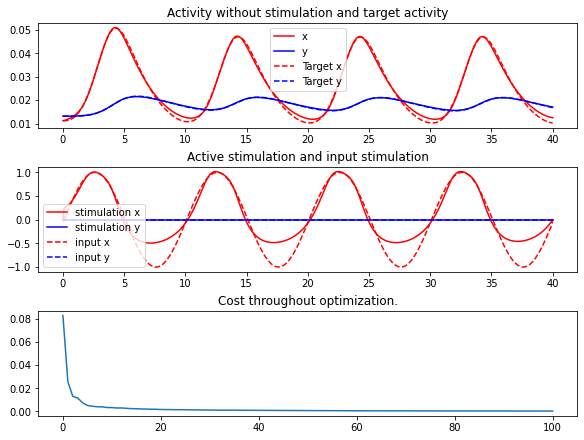

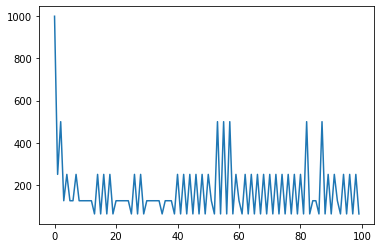

In [10]:
# We load the optimal control class
# print array (optional parameter) defines, for which iterations intermediate results will be printed
# Parameters will be taken from the input model
model.params["exc_ext"] = zero_input
model.params["inh_ext"] = zero_input
controlmat = np.zeros((1,2))
controlmat[0,0] = 1.
model_controlled = oc_wc.OcWc(model, target, w_p=1, w_2=0, print_array=np.arange(0,501,25), control_matrix = controlmat)

# We run 500 iterations of the optimal control gradient descent algorithm
#model_controlled.step = 100
model_controlled.optimize(100)

state = model_controlled.get_xs()
control = model_controlled.control

plot_oc_singlenode(duration, dt, state, target, control, target_input, model_controlled.cost_history)

plt.plot(model_controlled.step_sizes_history)
plt.show()


Compute control for a deterministic system
Cost in iteration 0: 1.0219337126068451e-06
Cost in iteration 25: 9.557065609690496e-07
Cost in iteration 50: 8.915227657327032e-07
Cost in iteration 75: 8.360627495414048e-07
Cost in iteration 100: 7.84550398270945e-07
Cost in iteration 125: 7.380449721280424e-07
Cost in iteration 150: 6.967338987755195e-07
Cost in iteration 175: 6.561783821923112e-07
Cost in iteration 200: 6.207577817800233e-07
Cost in iteration 225: 5.869299476597384e-07
Cost in iteration 250: 5.564614730441845e-07
Cost in iteration 275: 5.277763649126074e-07
Cost in iteration 300: 5.014442860529347e-07
Cost in iteration 325: 4.768148999454192e-07
Cost in iteration 350: 4.539330691495516e-07
Cost in iteration 375: 4.334407641969703e-07
Cost in iteration 400: 4.126147236007408e-07
Cost in iteration 425: 3.9457325105322216e-07
Cost in iteration 450: 3.7644309856511816e-07
Cost in iteration 475: 3.60500574873755e-07
Cost in iteration 500: 3.4459562301217764e-07
Final cost : 3.

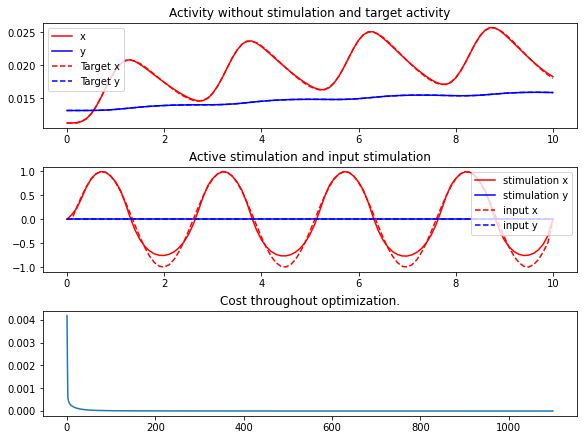

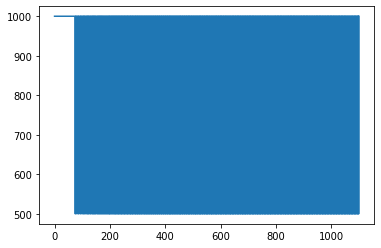

In [7]:
# Do another 100 iterations if you want to.
# Repeated execution will continue with further 100 iterations.
# model_controlled.step = 100
model_controlled.optimize(500)
state = model_controlled.get_xs()
control = model_controlled.control
plot_oc_singlenode(duration, dt, state, target, control, target_input, model_controlled.cost_history)

plt.plot(model_controlled.step_sizes_history)
plt.show()

### Network case

Let us know study a simple 2-node network of model oscillators. We first need to define the coupling matrix and the delay matrix. We can then initialize the model.

0.012553802828736098 0.011902994762594227
0.013492621933611138 0.013312219644721963


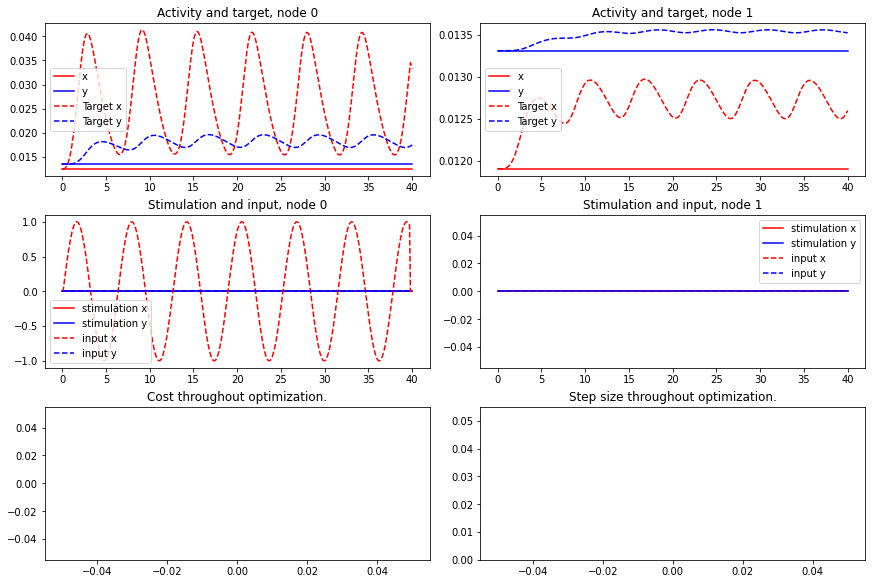

In [15]:
cmat = np.array( [[0., 1.], [0.5, 0.]] )  # diagonal elements are zero, connection strength is 1 (0.5) from node 0 to node 1 (from node 1 to node 0)
dmat = np.array( [[0., 0.], [0., 0.]] )  # no delay

model = WCModel(Cmat=cmat, Dmat=dmat)
model.params.coupling = "additive" # use additive coupling

# we define the control input matrix to enable or disable certain channels and nodes
control_mat = np.zeros( (model.params.N, len(model.state_vars)) )
control_mat[0,0] = 1. # only allow inputs in y-channel in node 0

model.params.K_gl = 5.

model.params["duration"] = duration
zero_input = ZeroInput().generate_input(duration=duration+dt, dt=dt)
input = np.copy(zero_input)
input[0,1:-3] = np.sin(np.arange(0,duration-0.3, dt)) # other functions or random values can be used as well
model.params["exc_init"] = np.vstack( [0.01255381969006173, 0.01190300495001282] )
model.params["inh_init"] = np.vstack( [0.013492631513639169, 0.013312224583806076] )


# We set the stimulus in x and y variables, and run the simulation
input_nw = np.concatenate( (np.vstack( [control_mat[0,0] * input, control_mat[0,1] * input] )[np.newaxis,:,:],
                            np.vstack( [control_mat[1,0] * input, control_mat[1,1] * input] )[np.newaxis,:,:]), axis=0)
zero_input_nw = np.concatenate( (np.vstack( [zero_input, zero_input] )[np.newaxis,:,:],
                                 np.vstack( [zero_input, zero_input] )[np.newaxis,:,:]), axis=0)

model.params["exc_ext"] = input_nw[:,0,:]
model.params["inh_ext"] = input_nw[:,1,:]

model.run()

# Define the result of the stimulation as target
target = np.concatenate( (np.concatenate( (model.params["exc_init"], model.params["inh_init"]), axis=1)[:,:, np.newaxis], np.stack( (model.exc, model.inh), axis=1)), axis=2)

# Remove stimuli and re-run the simulation
model.params["exc_ext"] = zero_input_nw[:,0,:]
model.params["inh_ext"] = zero_input_nw[:,0,:]
model.run()

print(model.exc[0,-1], model.exc[1,-1])
print(model.inh[0,-1], model.inh[1,-1])

# combine initial value and simulation result to one array
state =  np.concatenate( (np.concatenate( (model.params["exc_init"], model.params["inh_init"]), axis=1)[:,:, np.newaxis], np.stack( (model.exc, model.inh), axis=1)), axis=2)

plot_oc_network(model.params.N, duration, dt, state, target, zero_input_nw, input_nw)

Compute control for a deterministic system
Cost in iteration 0: 0.00012958985147117102
Cost in iteration 1: 0.00012556986902771135
Cost in iteration 2: 0.00012146437468574582
Cost in iteration 10: 8.589724166723555e-05
Final cost : 4.060427565615714e-05


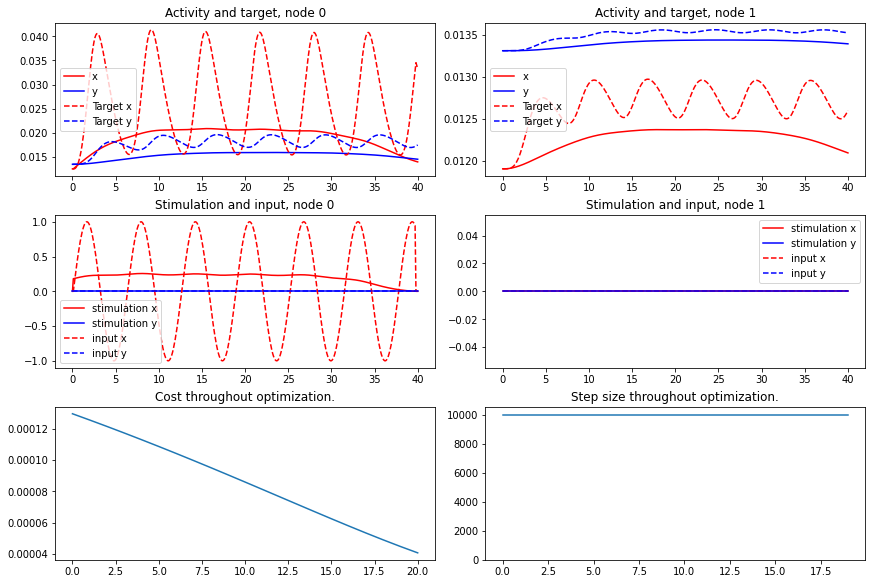

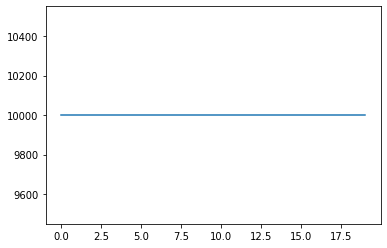

In [20]:
prec_mat = np.zeros( (model.params.N, len(model.output_vars)) )
prec_mat[1,0] = 1. # only measure in y-channel in node 1

model.params["exc_ext"] = zero_input_nw[:,0,:]
model.params["inh_ext"] = zero_input_nw[:,0,:]
model_controlled = oc_wc.OcWc(model, target, w_p=1, w_2=0, print_array=[1,2,10,50,100,200,300,400,500], control_matrix=control_mat, precision_matrix=prec_mat)

model_controlled.step = 10000
model_controlled.optimize(20)

state = model_controlled.get_xs()
control = model_controlled.control

plot_oc_network(model.params.N, duration, dt, state, target, control, input_nw, model_controlled.cost_history, model_controlled.step_sizes_history)

plt.plot(model_controlled.step_sizes_history)
plt.show()

Compute control for a deterministic system
Cost in iteration 0: 3.116662283743441e-09
Cost in iteration 1: 3.116057070094644e-09
Cost in iteration 2: 3.115452047163891e-09
Cost in iteration 10: 3.1106187208751495e-09
Cost in iteration 50: 3.0866338104311e-09
Cost in iteration 100: 3.057073310391204e-09
Cost in iteration 200: 2.999321088967618e-09
Cost in iteration 300: 2.943337182529358e-09
Cost in iteration 400: 2.889056010628527e-09
Cost in iteration 500: 2.8364147173109095e-09
Final cost : 1.9129544022293906e-09


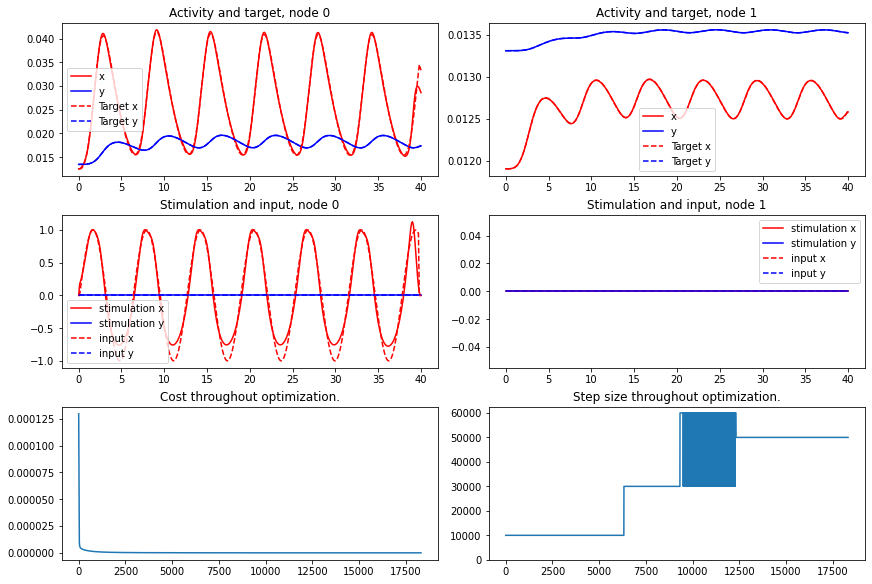

In [31]:
# Do another 100 iterations if you want to.
# Repeated execution will continue with further 100 iterations.
model_controlled.step = 50000
model_controlled.optimize(3000)
state = model_controlled.get_xs()
control = model_controlled.control
plot_oc_network(model.params.N, duration, dt, state, target, control, input_nw, model_controlled.cost_history, model_controlled.step_sizes_history)